# **Problem 1: Beer Simulation Game (40 Points)**

### Simulate the beer simulation game in simpy. Assume each time step corresponds to one week. Consider the supply chain that is similar to what you played in the game.Retailer → Wholesaler → Distributor → Factory. Assume a lead time that has a uniform distribution between one and four weeks. (The lead time can be one, two, three, or four weeks with equal probability). This lead time exists between all entities. Assume the customer demand is 100k with a probability of 15%, 150k with a probability of 15%, and 200k with a probability of 70 %. The cost of holding a case is 0.5 dollar and the cost of missing an order is $1. For each entity in the chain, assume the algorithm used to calculate the demand is similar to the newsvendor problem.

### Run the game for 50 timesteps.

### For the above game, submit the following: -

1. Plot the weekly costs of each entity as a function of time. 
2. Plot the inventory as a function of time.
3. Plot the orders placed by each entity as a function of time.


In [ ]:
! pip install simpy matplotlib numpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

! pip install scipy
import scipy.stats as stats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


we assume initial inventory of factory = 400000

In [ ]:
import random
import simpy
import matplotlib.pyplot as plt

# Constants
NUM_TIMESTEPS = 50
CUSTOMER_DEMAND = [100000, 150000, 200000]
DEMAND_PROBABILITIES = [0.15, 0.15, 0.7]
LEAD_TIME_MIN = 1
LEAD_TIME_MAX = 4
CASE_HOLDING_COST = 0.5
MISSING_ORDER_COST = 1

class BeerEntity:
    def __init__(self, env, name, downstream_entity=None, initial_inventory=0):
        self.env = env
        self.name = name
        self.downstream_entity = downstream_entity
        self.inventory = initial_inventory
        self.costs = []
        self.orders = []
        self.inventory_levels = []
        self.weekly_demand = []
        self.production_order = 0
        self.production_data = []
        # Start the entity's process
        self.action = env.process(self.run())

    def calculate_demand(self):
        if self.name == 'Customer':
            demand = self.calculate_customer_demand()
        else:
            demand = self.downstream_entity.receive_order()

        self.weekly_demand.append(demand)
        return demand

    def run(self):
        for timestep in range(NUM_TIMESTEPS):
            # Calculate demand
            if self.name == 'Produce':
                production = self.production_order
                self.inventory += production
                self.production_data.append(production)

            # Calculate demand
            demand = self.calculate_demand()

            # Check if inventory is enough to meet the demand
            if self.inventory >= demand:
                self.inventory -= demand
            else:
                # Calculate missing order cost
                missing_order_cost = (demand - self.inventory) * MISSING_ORDER_COST
                self.costs.append(missing_order_cost)
                self.inventory = 0

            # Calculate case holding cost
            case_holding_cost = self.inventory * CASE_HOLDING_COST
            self.costs.append(case_holding_cost)

            # Place order to downstream entity
            order = yield from self.place_order()
            self.orders.append(order)
            yield self.env.timeout(1)  # Move to next timestep
            self.inventory_levels.append(self.inventory)
            self.orders.append(order)

    def calculate_customer_demand(self):
        # Calculate the customer demand
        customer_demand = random.choices(CUSTOMER_DEMAND, DEMAND_PROBABILITIES)[0]
        return customer_demand

    def calculate_order_quantity(self):
        # Calculate the order quantity using the newsvendor method F(Q) = 1 / (1 + 0.5)
        order_quantity = round(self.calculate_demand() * (1 / (1 + 0.5)))
        return order_quantity
    
    def place_order(self):
        # Calculate lead time
        lead_time = random.randint(LEAD_TIME_MIN, LEAD_TIME_MAX)
       
        # Wait for lead time
        yield self.env.timeout(lead_time)
       
        # Place order to downstream entity
        if self.name == 'Produce':
            order = self.downstream_entity.receive_order()
        elif self.downstream_entity:
            order = self.downstream_entity.receive_order()
        else:
            order = 0

        if self.name == 'Factory':
            self.downstream_entity.production_order = order  # update distributor's order to the factory's order

        self.inventory += order
        return order  # Return the order quantity

    def receive_order(self):
        # Return the order quantity
        return random.choices(CUSTOMER_DEMAND, DEMAND_PROBABILITIES)[0]

# Create the simulation environment
env = simpy.Environment()

# Create entities
customer = BeerEntity(env, 'Customer')
retailer = BeerEntity(env, 'Retailer', downstream_entity=customer)
wholesaler = BeerEntity(env, 'Wholesaler', downstream_entity=retailer)
distributor = BeerEntity(env, 'Distributor', downstream_entity=wholesaler)
factory = BeerEntity(env, 'Factory', downstream_entity=distributor)
produce = BeerEntity(env, 'Produce', downstream_entity=factory, initial_inventory=400000)
# Run the simulation
env.run()

# Print weekly customer demand
print("Weekly Customer Demand:")
print(customer.weekly_demand)

# Print weekly retailer orders
print("Weekly Retailer Orders:")
print(retailer.orders)


Weekly Customer Demand:
[200000, 200000, 100000, 200000, 200000, 200000, 150000, 200000, 200000, 100000, 200000, 200000, 100000, 100000, 200000, 100000, 200000, 150000, 200000, 200000, 200000, 100000, 200000, 100000, 200000, 200000, 100000, 200000, 200000, 100000, 150000, 200000, 200000, 200000, 150000, 200000, 200000, 200000, 100000, 200000, 100000, 200000, 200000, 150000, 200000, 200000, 200000, 200000, 200000, 100000]
Weekly Retailer Orders:
[100000, 100000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 100000, 100000, 200000, 200000, 150000, 150000, 100000, 100000, 200000, 200000, 100000, 100000, 200000, 200000, 150000, 150000, 200000, 200000, 200000, 200000, 200000

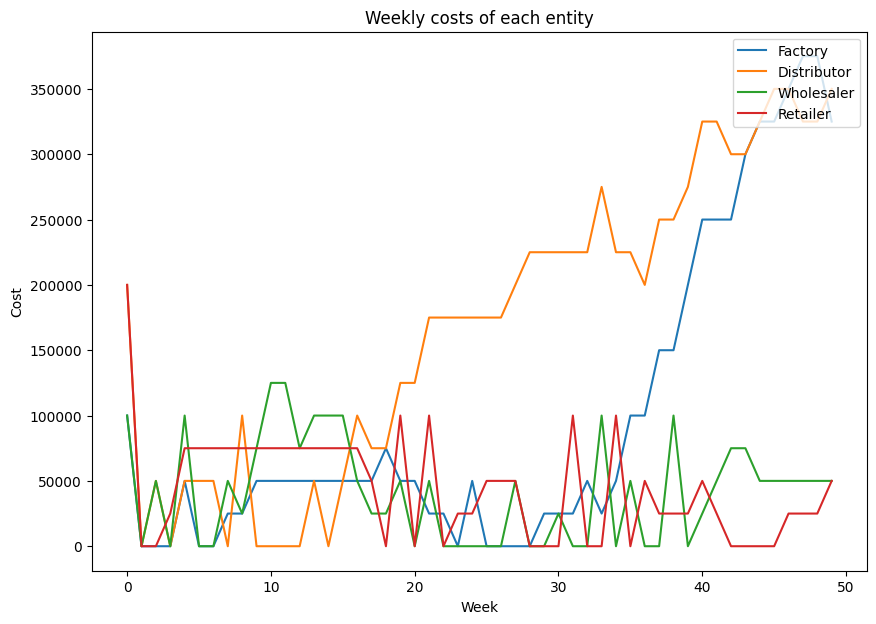

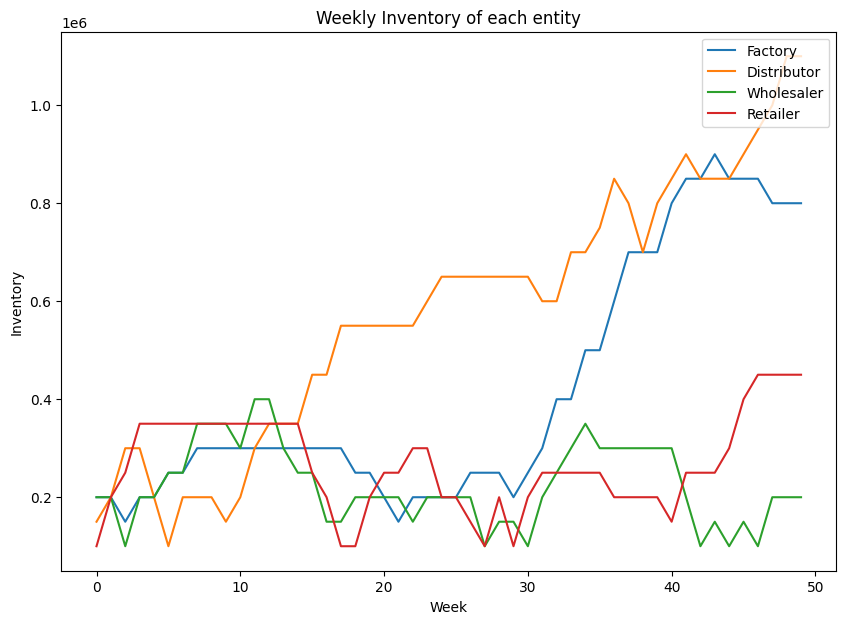

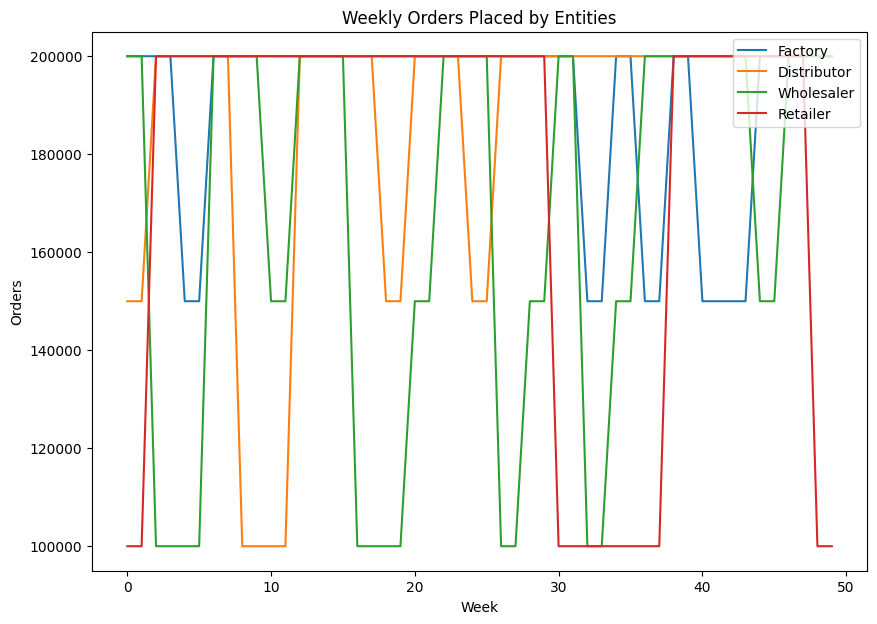

In [ ]:
# Plot the weekly costs of each entity
plt.figure(figsize=(10, 7))
plt.plot(range(NUM_TIMESTEPS), factory.costs[:NUM_TIMESTEPS], label='Factory')
plt.plot(range(NUM_TIMESTEPS), distributor.costs[:NUM_TIMESTEPS], label='Distributor')
plt.plot(range(NUM_TIMESTEPS), wholesaler.costs[:NUM_TIMESTEPS], label='Wholesaler')
plt.plot(range(NUM_TIMESTEPS), retailer.costs[:NUM_TIMESTEPS], label='Retailer')
plt.title('Weekly costs of each entity')
plt.xlabel('Week')
plt.ylabel('Cost')
plt.legend(loc='upper right')
plt.show()

# Plot the inventory of each entity
plt.figure(figsize=(10, 7))
plt.plot(range(NUM_TIMESTEPS), factory.inventory_levels[:NUM_TIMESTEPS], label='Factory')
plt.plot(range(NUM_TIMESTEPS), distributor.inventory_levels[:NUM_TIMESTEPS], label='Distributor')
plt.plot(range(NUM_TIMESTEPS), wholesaler.inventory_levels[:NUM_TIMESTEPS], label='Wholesaler')
plt.plot(range(NUM_TIMESTEPS), retailer.inventory_levels[:NUM_TIMESTEPS], label='Retailer')
plt.title('Weekly Inventory of each entity')
plt.xlabel('Week')
plt.ylabel('Inventory')
plt.legend(loc='upper right')
plt.show()

# Plot the orders placed by each entity
plt.figure(figsize=(10, 7))
plt.plot(range(NUM_TIMESTEPS), factory.orders[:NUM_TIMESTEPS], label='Factory')
plt.plot(range(NUM_TIMESTEPS), distributor.orders[:NUM_TIMESTEPS], label='Distributor')
plt.plot(range(NUM_TIMESTEPS), wholesaler.orders[:NUM_TIMESTEPS], label='Wholesaler')
plt.plot(range(NUM_TIMESTEPS), retailer.orders[:NUM_TIMESTEPS], label='Retailer')
plt.xlabel('Week')
plt.ylabel('Orders')
plt.title('Weekly Orders Placed by Entities')
plt.legend(loc='upper right')
plt.show()


# **Problem 2: Risk Pooling (30 points)**

### Simulate the risk pooling game as discussed in the lecture. For this problem as well, assume that a one-time step corresponds to one week. Consider two scenarios. One with two warehouses catering to the two different products (A, B), and the second scenario corresponds to a centralized warehouse. Assume the demand for products A and B for both warehouses in scenario one comes from normal distributions N(40,12) and N(1,1) respectively. Assume that the demand for the centralized warehouse in scenario 2 comes from N(80,20) and N(2, 2) respectively.

### Assume a random lead time of [1, 2] weeks. (i.e. the lead time can be 1 or 2 weeks with equal probability).
### Assume the warehouses use the (s, S) policy to manage inventory. Assume that the starting inventory for both warehouses in scenario 1 is 50 units and 2 units for products A and B respectively and for scenario 2 2, it is 80 units and 3 units respectively.

### Run this scenario for 100 timesteps.




### **1.Find out the stockout rate (fraction of time periods) in scenario 1 as well as scenario 2.**



To find the stockout rate in scenario 1 and scenario 2, we can simulate the inventory management process for 100 timesteps and calculate the fraction of time periods where stockouts occur.

**Answer** 

secrinro 1 Stockout rate: 0.03

secrinro 2 Stockout rate: 0.04

In [ ]:
import numpy as np
from scipy.stats import norm

#Define the parameters:
num_timesteps = 100
lead_time = [1, 2]  # Random lead time between 1 and 2 weeks

#lead time follow uniform distribution
mean_L =1.5
  
var_L = np.var([1, 2], ddof=0)

starting_inventory_scenario1 = {'A': 50, 'B': 2}  # Starting inventory for scenario 1
starting_inventory_scenario2 = {'A': 80, 'B': 3}  # Starting inventory for scenario 2
demand_mean_scenario1 = {'A': 40, 'B': 1}  # Mean demand for scenario 1
demand_std_scenario1 = {'A': 12, 'B': 1}  # Standard deviation of demand for scenario 1
demand_mean_scenario2 = {'A': 80, 'B': 2}  # Mean demand for scenario 2
demand_std_scenario2 = {'A': 20, 'B': 2}  # Standard deviation of demand for scenario 2

we assume :

serivce level = 0.97(Z=1.89),

holding_cost_per_week = 0.27,

order_cost = 60,

and base on the mean of demand and sd of demand given above, we calucate (s,S) value for each product in two scenarioes:

In [ ]:
import math

def s_policy(mean_L,var_L,mean_D,var_D,Z):
    s_policy = mean_D*mean_L + Z * math.sqrt(mean_L*var_D + mean_D*mean_D*var_L)  
    return s_policy    

def S_policy(s_policy,mean_D,order_cost,holding_cost):
    S_policy = s_policy + math.sqrt((2*mean_D*order_cost)/holding_cost)
    return S_policy   

scenario 1:

In [ ]:
# s_policy_scenario1-product A
s1A = s_policy(1.5,var_L,40,12,1.89)
s1A

98.64114128749304

In [ ]:
# S_policy_scenario1-product A
S1A = S_policy(s1A,40,60,0.27)
S1A

231.97447462082638

In [ ]:
# s_policy_scenario1-product B
s1B = s_policy(1.5,var_L,1,1,1.89)
s1B

4.000234988956038

In [ ]:
# S_policy_scenario1-product B
S1B = S_policy(s1B,1,60,0.27)
S1B

25.082086056745233

scenario2:

In [ ]:
# s_policy_scenario2-product A
s2A = s_policy(1.5,var_L,80,20,1.89)
s2A

196.3054585203444

In [ ]:
# S_policy_scenario2-product A
S2A = S_policy(s2A,80,60,0.27)
S2A

384.86726683675704

In [ ]:
# s_policy_scenario2-product B
s2B = s_policy(1.5,var_L,2,2,1.89)
s2B

6.779999999999999

In [ ]:
# S_policy_scenario1-product B
S2B = S_policy(s2B,2,60,0.27)
S2B

36.594239699997196

In [ ]:
print(f"For Scenario 1, Product A: s = {s1A}, S = {S1A}")
print(f"For Scenario 1, Product B: s = {s1B}, S = {S1B}")
print(f"For Scenario 2, Product A: s = {s2A}, S = {S2A}")
print(f"For Scenario 2, Product B: s = {s2B},S = {S2B}")

For Scenario 1, Product A: s = 98.64114128749304, S = 231.97447462082638
For Scenario 1, Product B: s = 4.000234988956038, S = 25.082086056745233
For Scenario 2, Product A: s = 196.3054585203444, S = 384.86726683675704
For Scenario 2, Product B: s = 6.779999999999999,S = 36.594239699997196


In [ ]:
#Define the (s, S) policy:
s_policy_scenario1 = {'A': s1A, 'B': s1B}  # Reorder point for scenario 1
S_policy_scenario1 = {'A': S1A, 'B': S1B}  # Order-up-to level for scenario 1
s_policy_scenario2 = {'A': s2A, 'B': s2B}  # Reorder point for scenario 2
S_policy_scenario2 = {'A': S2A, 'B':  S2B}  # Order-up-to level for scenario 2

### scenario 1

In [ ]:
### secrinro 1
import simpy
import numpy as np

# Parameters
sim_duration = 100  # Duration of simulation in weeks
initial_inventory = {'A': 50, 'B': 2}  # Initial inventory level for each product
s_policy = {'A': s1A, 'B': s1B}  # Reorder point for each product
S_policy = {'A': S1A, 'B': S1B}  # Order-up-to level for each product
lead_time = [1, 2]  # Possible lead times
demand_mean = {'A': 40, 'B': 1}  # Mean demand for each product
demand_std = {'A': 12, 'B': 1}  # Demand standard deviation for each product

class Warehouse(object):
    def __init__(self, env, initial_inventory, s_policy, S_policy):
        self.env = env
        self.inventory = {product: simpy.Container(env, init=initial_inventory[product]) for product in initial_inventory.keys()}
        self.s_policy = s_policy
        self.S_policy = S_policy
        self.stockouts = 0

    def manage_inventory(self):
        while True:
            for product in self.inventory.keys():
                if self.inventory[product].level <= self.s_policy[product]:
                    yield env.process(self.replenish_inventory(product))
            yield self.env.timeout(1)  # Wait for one week

    def replenish_inventory(self, product):
        yield self.env.timeout(np.random.choice(lead_time))  # Wait for lead time
        amount_to_replenish = self.S_policy[product] - self.inventory[product].level
        #print(f"Replenishing inventory of {product} by {amount_to_replenish} units at time {self.env.now}")
        self.inventory[product].put(amount_to_replenish)


    def demand(self):
      while True:
        for product in self.inventory.keys():
            demand = max(0, np.random.normal(demand_mean[product], demand_std[product]))
            if demand > 0:
                if demand > self.inventory[product].level:
                    self.stockouts += 1
                yield self.inventory[product].get(demand)
        yield self.env.timeout(1)  # Wait for one week

# Create the simulation environment
env = simpy.Environment()

# Create the warehouse
warehouse = Warehouse(env, initial_inventory, s_policy, S_policy)

# Add the inventory management and demand processes
env.process(warehouse.manage_inventory())
env.process(warehouse.demand())

# Run the simulation
env.run(until=sim_duration)

# Calculate the stockout rate
stockout_rate = warehouse.stockouts / (sim_duration * len(initial_inventory))
print(f" secrinro 1 Stockout rate: {stockout_rate}")

 secrinro 1 Stockout rate: 0.03


### scenario 2

In [ ]:
### secrinro 2

# Parameters
sim_duration = 100  # Duration of simulation in weeks
initial_inventory = {'A': 80, 'B': 3}  # Initial inventory level for each product
s_policy = {'A': s2A, 'B': s2B}  # Reorder point for scenario 2
S_policy =  {'A': S2A, 'B':  S2B}  # Order-up-to level for scenario 2
lead_time = [1, 2]  # Possible lead times
demand_mean = {'A': 80, 'B': 2}  # Mean demand for each product
demand_std = {'A': 20, 'B': 2}  # Demand standard deviation for each product

class Warehouse(object):
    def __init__(self, env, initial_inventory, s_policy, S_policy):
        self.env = env
        self.inventory = {product: simpy.Container(env, init=initial_inventory[product]) for product in initial_inventory.keys()}
        self.s_policy = s_policy
        self.S_policy = S_policy
        self.stockouts = 0

    def manage_inventory(self):
        while True:
            for product in self.inventory.keys():
                if self.inventory[product].level <= self.s_policy[product]:
                    yield env.process(self.replenish_inventory(product))
            yield self.env.timeout(1)  # Wait for one week

    def replenish_inventory(self, product):
        yield self.env.timeout(np.random.choice(lead_time))  # Wait for lead time
        amount_to_replenish = self.S_policy[product] - self.inventory[product].level
        #print(f"Replenishing inventory of {product} by {amount_to_replenish} units at time {self.env.now}")
        self.inventory[product].put(amount_to_replenish)

    def demand(self):
        while True:
            for product in self.inventory.keys():
                demand = max(0, np.random.normal(demand_mean[product], demand_std[product]))
                if demand > 0:
                    if demand > self.inventory[product].level:
                        self.stockouts += 1
                    yield self.inventory[product].get(demand)
            yield self.env.timeout(1)  # Wait for one week

# Create the simulation environment
env = simpy.Environment()

# Create the warehouse
warehouse = Warehouse(env, initial_inventory, s_policy, S_policy)

# Add the inventory management and demand processes
env.process(warehouse.manage_inventory())
env.process(warehouse.demand())

# Run the simulation
env.run(until=sim_duration)

# Calculate the stockout rate
stockout_rate = warehouse.stockouts / (sim_duration * len(initial_inventory))
print(f"Stockout rate: {stockout_rate}")

Stockout rate: 0.04


### **2.Compare the total holding inventory in both scenarios over the total time. (use the same parameters for holding cost, ordering cost, and service rate as mentioned in the lecture notes. )**



Scenario 1 Total Holding Inventory:  4062.4705169572785

Scenario 2 Total Holding Inventory:  7806.972223303271

In [ ]:
# Define the holding cost and order cost:
holding_cost_per_week = 0.27
order_cost = 60
service_level = 0.97

In [ ]:
# Parameters
sim_duration = 100  # Duration of simulation in weeks
initial_inventory_scenario1 = {'A': 50, 'B': 2}  # Initial inventory level for scenario 1
initial_inventory_scenario2 = {'A': 80, 'B': 3}  # Initial inventory level for scenario 2

#Define the (s, S) policy:
s_policy_scenario1 = {'A': s1A, 'B': s1B}  # Reorder point for scenario 1
S_policy_scenario1 = {'A': S1A, 'B': S1B}  # Order-up-to level for scenario 1
s_policy_scenario2 = {'A': s2A, 'B': s2B}  # Reorder point for scenario 2
S_policy_scenario2 = {'A': S2A, 'B':  S2B}  # Order-up-to level for scenario 2

lead_time = [1, 2]  # Possible lead times
demand_mean_scenario1 = {'A': 40, 'B': 1}  # Mean demand for scenario 1
demand_std_scenario1 = {'A': 12, 'B': 1}  # Standard deviation of demand for scenario 1
demand_mean_scenario2 = {'A': 80, 'B': 2}  # Mean demand for scenario 2
demand_std_scenario2 = {'A': 20, 'B': 2}  # Standard deviation of demand for scenario 2

class Warehouse(object):
    def __init__(self, env, initial_inventory, s_policy, S_policy):
        self.env = env
        self.inventory = {product: simpy.Container(env, init=initial_inventory[product]) for product in initial_inventory.keys()}
        self.total_holding_inventory = {product: 0 for product in initial_inventory.keys()}
        self.s_policy = s_policy
        self.S_policy = S_policy

    def manage_inventory(self):
        while True:
            for product in self.inventory.keys():
                if self.inventory[product].level <= self.s_policy[product]:
                    yield env.process(self.replenish_inventory(product))
            yield self.env.timeout(1)  # Wait for one week

    def replenish_inventory(self, product):
        yield self.env.timeout(np.random.choice(lead_time))  # Wait for lead time
        amount_to_replenish = self.S_policy[product] - self.inventory[product].level
        yield self.inventory[product].put(amount_to_replenish)

    def demand(self, demand_mean, demand_std):
        while True:
            for product in self.inventory.keys():
                demand = max(0, np.random.normal(demand_mean[product], demand_std[product]))
                if demand > 0:
                    if demand > self.inventory[product].level:
                        self.total_holding_inventory[product] += self.inventory[product].level
                    else:
                        self.total_holding_inventory[product] += demand
                        yield self.inventory[product].get(demand)
            yield self.env.timeout(1)  # Wait for one week

# Run simulation for Scenario 1
env = simpy.Environment()
warehouse1 = Warehouse(env, initial_inventory_scenario1, s_policy_scenario1, S_policy_scenario1)
env.process(warehouse1.manage_inventory())
env.process(warehouse1.demand(demand_mean_scenario1, demand_std_scenario1))
env.run(until=sim_duration)

# Print the total holding inventory for Scenario 1
total_holding_inventory_scenario1 = sum(warehouse1.total_holding_inventory.values())
print("Scenario 1 Total Holding Inventory: ", total_holding_inventory_scenario1)

# Run simulation for Scenario 2
env = simpy.Environment()
warehouse2 = Warehouse(env, initial_inventory_scenario2, s_policy_scenario2, S_policy_scenario2)
env.process(warehouse2.manage_inventory())
env.process(warehouse2.demand(demand_mean_scenario2, demand_std_scenario2))
env.run(until=sim_duration)

# Print the total holding inventory for Scenario 2
total_holding_inventory_scenario2 = sum(warehouse2.total_holding_inventory.values())
print("Scenario 2 Total Holding Inventory: ", total_holding_inventory_scenario2)

Scenario 1 Total Holding Inventory:  4062.4705169572785
Scenario 2 Total Holding Inventory:  7806.972223303271
